# Spectral Paper Algorithm 1

In [6]:
import numpy as np
from scipy.stats import norm
from scipy.linalg import svd
import matplotlib.pyplot as plt

In [ ]:
# Example usage
# Covariance matrix: only consider ones that is diagonal - easy to reverse
Sigma_example = np.array([[0.1, 0], [0, 0.1]])  

B_example = np.array([[0.9, 0.05], [0.05, 0.9]])  # Lag operator matrix
ny_example = 25  # Number of grid points
r = 25

In [8]:
def tauchen_var(Sigma, B, ny):
    """
    Compute the Markov transition matrix (P) and the grid (G) to match MATLAB results exactly.

    Parameters:
        Sigma (numpy.ndarray): Covariance matrix of shocks (MxM).
        B (numpy.ndarray): Lag operator matrix (MxM).
        ny (int): Number of grid points.

    Returns:
        P (numpy.ndarray): Markov transition matrix (NxN).
        G (numpy.ndarray): Grid (NxM).
    """
    # Dimensions
    M = B.shape[0]  # Number of random variables
    nSig = 3  # Fixed grid spacing

    # Compute unconditional variance
    Sigy = np.linalg.solve(np.eye(M) - np.dot(B.T, B), Sigma)
    stdy = np.sqrt(np.diag(Sigy))

    # Create grid points
    grids = [np.linspace(-nSig * stdy[m], nSig * stdy[m], ny) for m in range(M)]
    G = np.array(np.meshgrid(*grids, indexing="ij")).reshape(M, -1).T

    # Create bounds
    edges = [
        np.hstack([-np.inf, 0.5 * (grids[m][1:] + grids[m][:-1]), np.inf]) for m in range(M)
    ]
    lower_bounds = np.array(np.meshgrid(*[edges[m][:-1] for m in range(M)], indexing="ij")).reshape(M, -1).T
    upper_bounds = np.array(np.meshgrid(*[edges[m][1:] for m in range(M)], indexing="ij")).reshape(M, -1).T

    # Transition matrix
    N = G.shape[0]
    P = np.zeros((N, N))
    mu = np.dot(G, B.T)
    stde = np.sqrt(np.diag(Sigma))

    for i in range(N):
        for j in range(N):
            prob = 1
            for m in range(M):
                lower = (lower_bounds[j, m] - mu[i, m]) / stde[m]
                upper = (upper_bounds[j, m] - mu[i, m]) / stde[m]
                prob *= max(0, norm.cdf(upper) - norm.cdf(lower))
            P[i, j] = prob

    # Normalize probabilities
    P /= P.sum(axis=1, keepdims=True)

    return P, G


In [ ]:
def algorithm1(P, G, r):
    # Perform SVD and reduce dimensions
    # Set desired rank for dimensionality reduction
    U, S, Vt = svd(P, full_matrices=False)  # Economy SVD for potentially non-square P
    S_matrix = np.diag(S)
    V = Vt.T

    # Cumulative energy criterion to select r dynamically
    # cumulative_energy = np.cumsum(S) / np.sum(S)
    # r = np.argmax(cumulative_energy >= 0.95) + 1  # Find first r for 95% energy

    # Select the first r rows and columns
    U_r = U[:r, :r]          # First r rows and columns of U
    S_r = np.diag(S[:r])     # First r singular values (as a diagonal matrix)
    V_r = V[:r, :r]         # First r rows and columns of V
    V_rt = V_r.T

    Psmall = U_r @ S_r @ V_rt  # Rank-r approximation of P

    # Truncate negative values and normalize rows
    Psmall = np.maximum(Psmall, 0)  # Truncate negative values
    Psmall = Psmall / Psmall.sum(axis=1, keepdims=True)  # Normalize rows

    # Calculate weights matrix directly from V
    Weights = V[:r, :]  

    # Calculate Gsmall as a weighted average in reduced space
    Gsmall = Weights @ G


    # Calculate the range of the blue points (original grid G)
    blue_min = np.min(G, axis=0)  # Minimum values in each dimension [min_x, min_y]
    blue_max = np.max(G, axis=0)  # Maximum values in each dimension [max_x, max_y]

    # Check which red points (reduced grid Gsmall) fall within the blue range
    within_x_range = (Gsmall[:, 0] >= blue_min[0]) & (Gsmall[:, 0] <= blue_max[0])
    within_y_range = (Gsmall[:, 1] >= blue_min[1]) & (Gsmall[:, 1] <= blue_max[1])

    # Combine conditions to find points within both x and y range
    within_range = within_x_range & within_y_range

    # Count the number of red points within the range
    num_within_range = np.sum(within_range)

    # Calculate the ratio
    ratio = num_within_range / Gsmall.shape[0]

    # Debugging and dimension checks
    print(f"Initial P dimension: {P.shape}")
    print(f"Initial G dimension: {G.shape}")
    print(f"U dimension: {U.shape}")
    print(f"S dimension: {S.shape}")
    print(f"S_matrix dimension: {S_matrix.shape}")
    print(f"V dimension: {V.shape}")
    print(f"U_r dimension: {U_r.shape}")
    print(f"S_r dimension: {S_r.shape}")
    print(f"V_r dimension: {V_r.shape}")
    print(f"Psmall dimension (low-rank approximation): {Psmall.shape}")
    print(f"Psmall dimension (normalized): {Psmall.shape}")
    print(f"Weights dimension: {Weights.shape}")
    print(f"Gsmall dimension: {Gsmall.shape}")
    print(f"Number of red points within the range of blue points: {num_within_range}")
    print(f"Total number of red points: {Gsmall.shape[0]}")
    print(f"Ratio (Preservation Metric): {ratio:.4f}")
    print(f"Percentage within range: {ratio * 100:.2f}%")

    # Visualization
    plt.figure()
    plt.scatter(G[:, 0], G[:, 1], color='blue', label='Original Grid (Blue)', s=10)
    plt.scatter(Gsmall[:, 0], Gsmall[:, 1], color='red', label='Reduced Grid (Red)', s=10)
    plt.title('Original Grid (Blue) vs Reduced Grid (Red)')
    plt.xlabel('Dim 1')
    plt.ylabel('Dim 2')
    plt.legend()
    plt.show()

    return Psmall, Gsmall, ratio

In [ ]:
# Compute the Markov transition matrix and grid
P, G = tauchen_var(Sigma_example, B_example, ny_example)

# Use Algorithm 1
Psmall, Gsmall, ratio = algorithm1(P, G, r)

In [ ]:
# Run simulation for the Psmall and Gsamll



Initial P dimension: (625, 625)
Initial G dimension: (625, 2)
U dimension: (625, 625)
S dimension: (625,)
S_matrix dimension: (625, 625)
V dimension: (625, 625)
U_r dimension: (25, 25)
S_r dimension: (25, 25)
V_r dimension: (25, 25)
Psmall dimension (low-rank approximation): (25, 25)
Psmall dimension (normalized): (25, 25)
Weights dimension: (25, 625)
Gsmall dimension: (25, 2)
Number of red points within the range of blue points: 17
Total number of red points: 25
Ratio (Preservation Metric): 0.6800
Percentage within range: 68.00%


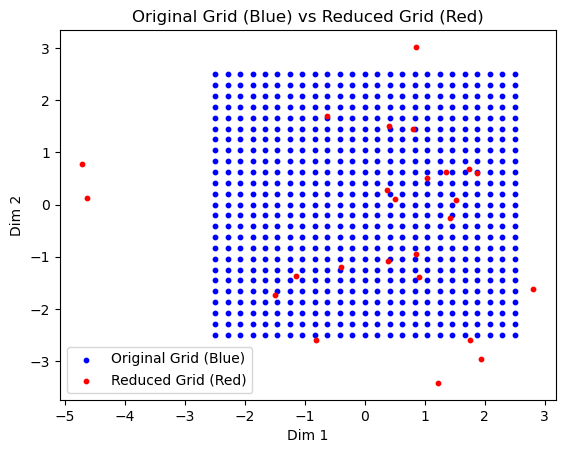

Transition Matrix (P):
[[2.24451992e-001 1.18163748e-001 8.11323465e-002 ... 0.00000000e+000
  0.00000000e+000 0.00000000e+000]
 [1.17579437e-001 1.12761028e-001 1.12761028e-001 ... 0.00000000e+000
  0.00000000e+000 0.00000000e+000]
 [4.72577352e-002 7.66587642e-002 1.11648279e-001 ... 0.00000000e+000
  0.00000000e+000 0.00000000e+000]
 ...
 [1.30011536e-094 1.02266060e-090 5.22930066e-087 ... 1.11648279e-001
  7.66587642e-002 4.72577352e-002]
 [1.70657056e-098 1.97846667e-094 1.49074264e-090 ... 1.12761028e-001
  1.12761028e-001 1.17579437e-001]
 [1.57812538e-102 2.69688305e-098 2.99482655e-094 ... 8.11323465e-002
  1.18163748e-001 2.24451992e-001]]

Grid (G):
[[-2.4973999  -2.4973999 ]
 [-2.4973999  -2.28928324]
 [-2.4973999  -2.08116658]
 ...
 [ 2.4973999   2.08116658]
 [ 2.4973999   2.28928324]
 [ 2.4973999   2.4973999 ]]

Low-rank Approximation (Psmall):
[[2.29449716e-01 1.85887102e-01 1.99138619e-01 1.67997080e-01
  1.13747170e-01 5.85325075e-02 1.54059938e-02 0.00000000e+00
  0.

In [ ]:
# Print result
print(f"Transition Matrix (P):\n{P}")
print(f"\nGrid (G):\n{G}")
print(f"\nLow-rank Approximation (Psmall):\n{Psmall}")
print(f"\nReduced Grid (Gsmall):\n{Gsmall}")
print(f"\nRatio of points within range: {ratio}")